# **Cliff World**

**Start state:** Bottom left

**Goal state:** Bottom right

**Cliff:** Bottom row (between start state and goal state)

**Actions:** 0 (up), 1 (down), 2 (left) and 3 (right)

**Rewards:** -100 for falling into cliff, -1 otherwise

# Imports

In [156]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
from tqdm import tqdm
import prettytable as pt
from collections import defaultdict, deque

# Parameters

In [157]:
CLIFF_WIDTH = 12
CLIFF_HEIGHT = 4
START_POINT = [3, 0] # bottom left
END_POINT = [3, 11] # bottom right

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

EPSILON = 0.1 # exploration factor
ALPHA = 0.5 # learning rate
GAMMA = 1 # discount factor

# Utility function for plotting value function

In [158]:
def plotValueFunction(Qtable, title):
	V = []
	plt.figure(dpi=600)
	for i in range(0, CLIFF_HEIGHT):
		for j in range(0, CLIFF_WIDTH):
			V.append(np.max(Qtable[i, j, :]))
	V = np.reshape(V, (4,12))
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='autumn')
	for (j,i),label in np.ndenumerate(V):
		ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title(title)
	plt.show()

# Function to get next state from current state using action taken

In [159]:
def nextState(state, action):
    rows, cols = state
    reward = -1 # default reward

    # max and min ensure that the agent does not move outside the grid
    if action == UP:
        next_state = [max(rows - 1, 0), cols]
    elif action == DOWN:
        next_state = [min(rows + 1, CLIFF_HEIGHT - 1), cols]
    elif action == LEFT:
        next_state = [rows, max(cols -1 , 0)]
    elif action == RIGHT:
        next_state = [rows, min(cols + 1, CLIFF_WIDTH - 1)]

    # if fall in cliff then reward of -100 and startover
    if action == DOWN:
        if next_state[0] == 3 and next_state[1] in range(1, 11):
            reward = -100
            next_state = START_POINT
    if action == RIGHT and state == START_POINT:
            reward = -100
            next_state = START_POINT

    return next_state, reward

# Function to extract optimal policy from Q-table

In [160]:
def optimalPolicy(Qtable):
    optimal_policy = []
    for i in range(0, CLIFF_HEIGHT):
        optimal_policy.append([])
        for j in range(0, CLIFF_WIDTH):
            if [i, j] == END_POINT:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(Qtable[i, j, :])
            if bestAction == UP:
                optimal_policy[-1].append(u'\u2191')
            elif bestAction == DOWN:
                optimal_policy[-1].append(u'\u2193')
            elif bestAction == LEFT:
                optimal_policy[-1].append(u'\u2190')
            elif bestAction == RIGHT:
                optimal_policy[-1].append(u'\u2192')
    return optimal_policy

# Utility function to find path using optimal policy

In [161]:
def findWay(optimal_policy):
    currentStatus = '?'
    currentPos = [3, 0]

    while currentStatus != 'G':
        currentStatus = optimal_policy[currentPos[0]][currentPos[1]]
        optimal_policy[currentPos[0]][currentPos[1]] = '*'
        if currentStatus == u'\u2191':
            currentPos[0] -= 1
        elif currentStatus == u'\u2193':
            currentPos[0] += 1
        elif currentStatus == u'\u2190':
            currentPos[1] -= 1
        elif currentStatus == u'\u2192':
            currentPos[1] += 1

    for i in range(0, CLIFF_HEIGHT):
        for j in range(0, CLIFF_WIDTH):
            currentStatus = optimal_policy[i][j]
            if currentStatus != '*':
                optimal_policy[i][j]=''
    return optimal_policy

# Utility function to display optimal policy

In [162]:
def prettyTable(optimal_policy):
    tb = pt.PrettyTable()
    for row in optimal_policy:
        tb.add_row(row)
    tb.header = False
    print(tb)

# Epsilon-greedy policy

In [163]:
def epsilonGreedy(state, Qtable):
    return np.random.choice(ACTIONS) if random.random() <= EPSILON else np.argmax(Qtable[state[0], state[1], : ])

# **SARSA**



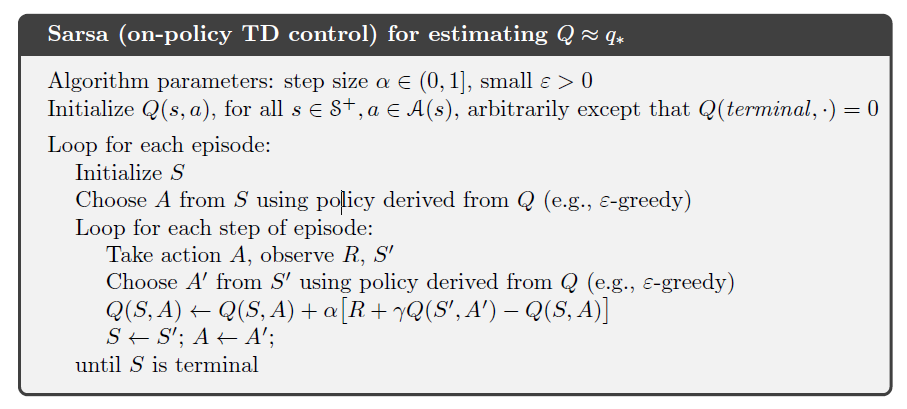

In [164]:
def sarsa(Qtable):
    state = START_POINT
    action = epsilonGreedy(state, Qtable)
    total_reward = 0 # for plotting graph
    while state != END_POINT:
        next_state, reward = nextState(state, action)
        next_action = epsilonGreedy(next_state, Qtable)
        total_reward += reward # for plotting graph
        target = reward + GAMMA * Qtable[next_state[0], next_state[1], next_action]
        current = Qtable[state[0], state[1], action]
        update_Qtable = ALPHA * (target - current)
        Qtable[state[0], state[1], action] += update_Qtable # SARSA update

        state = next_state
        action = next_action
    return total_reward

In [165]:
def testSarsa(episodes, runs, reward_on_each_episode):
    Qtable = np.zeros((CLIFF_HEIGHT, CLIFF_WIDTH, 4))
    for r in tqdm(range(runs)):
        for i in range(0, episodes):
            reward_on_each_episode[i] += sarsa(Qtable)
    reward_on_each_episode /= runs
    return reward_on_each_episode, Qtable

# **Q-Learning**

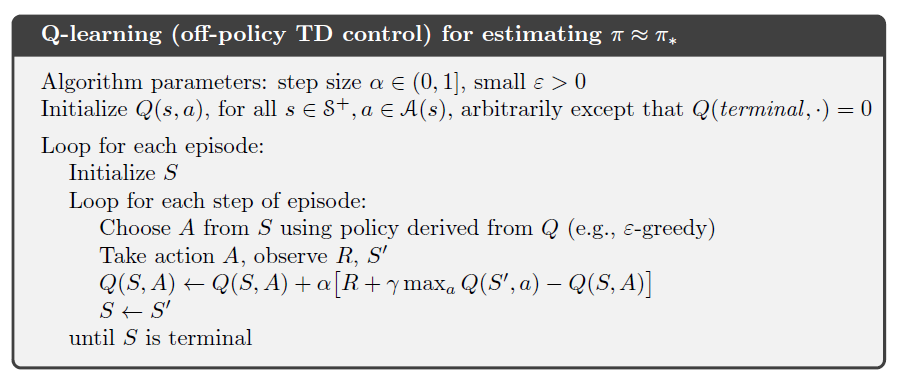

In [166]:
def Qlearning(Qtable):
    state = START_POINT
    total_reward = 0 # for plotting graph
    while state != END_POINT:
        action = epsilonGreedy(state, Qtable)
        next_state, reward = nextState(state, action)
        total_reward += reward # for plotting graph
        target = reward + GAMMA * np.max(Qtable[next_state[0], next_state[1], : ])
        current = Qtable[state[0], state[1], action]
        update_Qtable = ALPHA * (target - current)
        Qtable[state[0], state[1], action] += update_Qtable # Q-Learning update

        state = next_state
    return total_reward

In [167]:
def testQlearning(episodes, runs, reward_on_each_episode):
    Qtable = np.zeros((CLIFF_HEIGHT, CLIFF_WIDTH, 4))
    for r in tqdm(range(runs)):
        for i in range(0, episodes):
            reward_on_each_episode[i] += Qlearning(Qtable)
    reward_on_each_episode /= runs
    return reward_on_each_episode, Qtable

# Function for training

In [168]:
def train():
    episodes = 500 # number of episodes
    runs = 50 # number of runs

    reward_on_each_episode_sarsa = np.zeros(episodes)
    reward_on_each_episode_Qlearning = np.zeros(episodes)

    reward_on_each_episode_sarsa, sarsaQtable= testSarsa(episodes, runs, reward_on_each_episode_sarsa)
    reward_on_each_episode_Qlearning, QlearnningQtable =testQlearning(episodes, runs, reward_on_each_episode_Qlearning)

    optimal_policy_sarsa = optimalPolicy(sarsaQtable)
    optimal_policy_Qlearning = optimalPolicy(QlearnningQtable)
    print("SARSA Optimal Policy")
    prettyTable(optimal_policy_sarsa)
    print("Q-Learning Optimal Policy")
    prettyTable(optimal_policy_Qlearning)

    sarsa_path = findWay(optimal_policy_sarsa)
    Qlearning_path = findWay(optimal_policy_Qlearning)

    print("SARSA Optimal Path")
    prettyTable(sarsa_path)
    print("Q-Learning Optimal Path")
    prettyTable(Qlearning_path)

    plt.figure(dpi=600)
    plt.plot(reward_on_each_episode_sarsa, label='SARSA')
    plt.plot(reward_on_each_episode_Qlearning, label='Q-Learning')
    plt.xlabel('Number of epochs')
    plt.ylabel('Mean reward per epoch')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()

    plotValueFunction(sarsaQtable, "SARSA Value Function")
    plotValueFunction(QlearnningQtable, "Q-Learning Value Function")

# Training

100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


SARSA Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| → | → | → | → | → | → | → | → | → | → | ↓ | ↓ |
| → | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | ↑ | ← | → | → | ↑ | ↑ | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| ↑ | → | ↓ | → | → | ↓ | ↑ | → | → | → | → | ↓ |
| ↑ | → | ← | ← | ↑ | → | ↓ | ↓ | ← | → | ↓ | ↓ |
| → | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
SARSA Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |   |
| * | * | * | * | * | * | * | * | * | * | * | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Path
+---+---+-

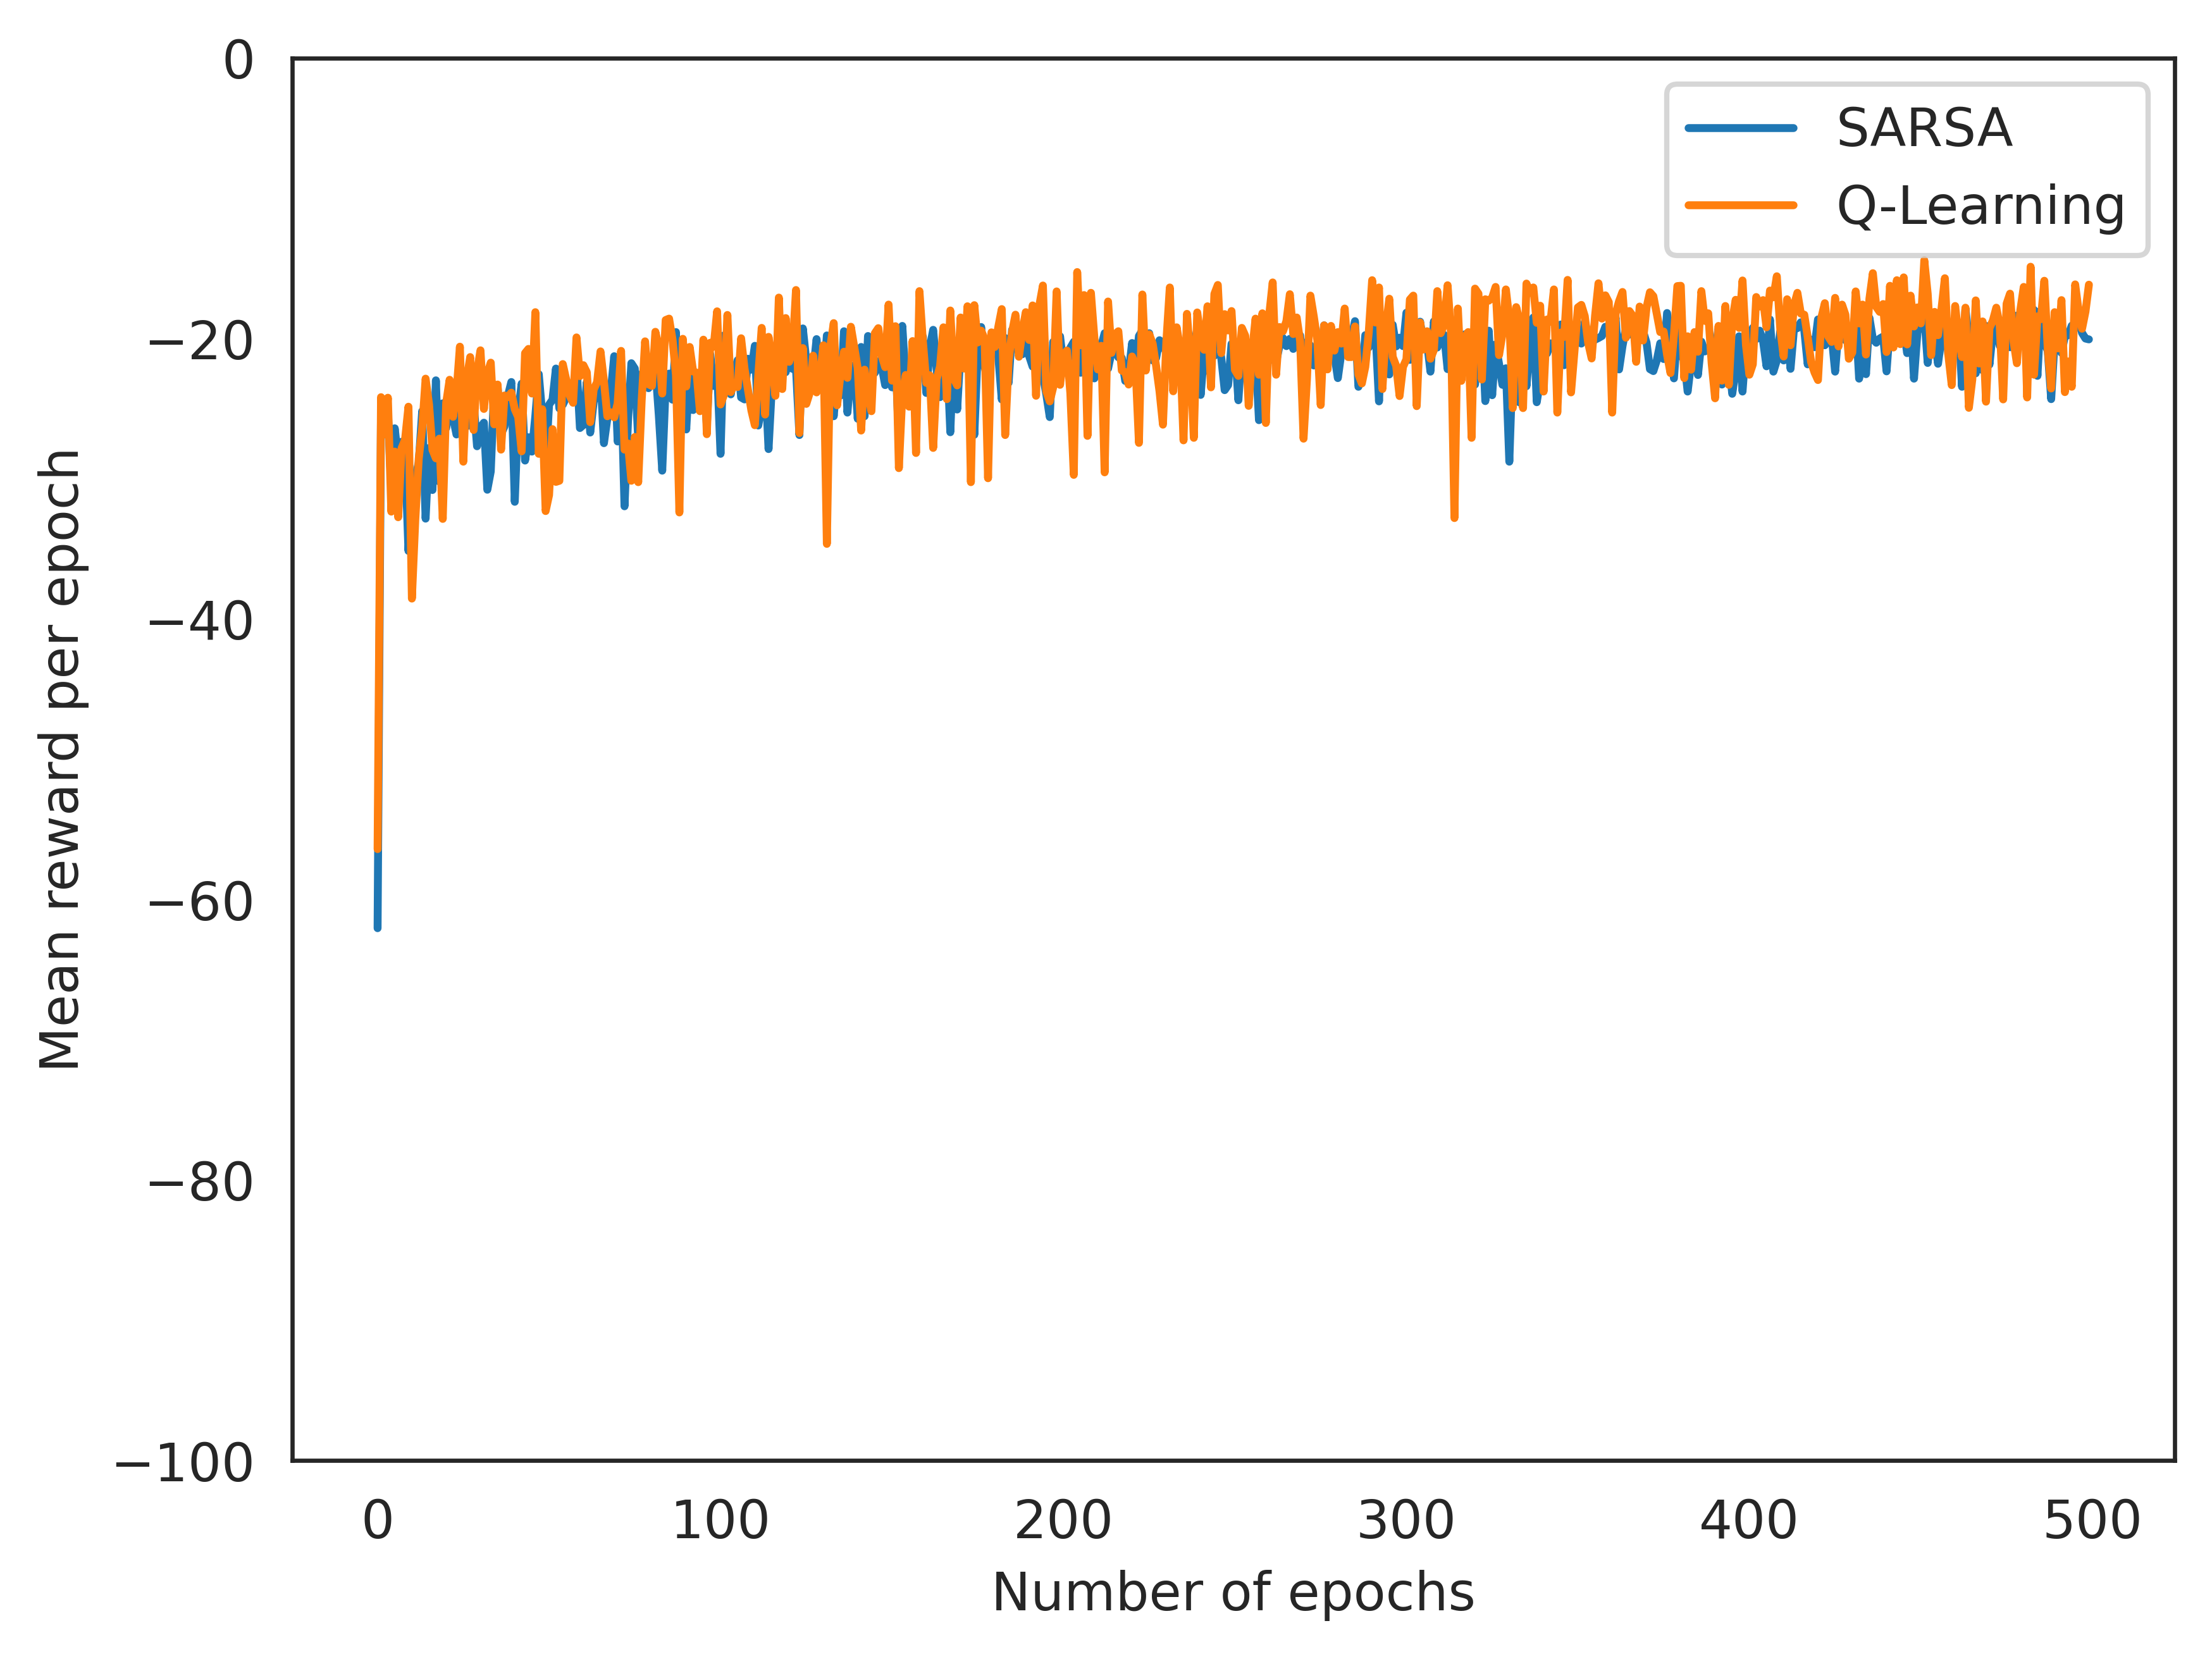

<Figure size 3840x2880 with 0 Axes>

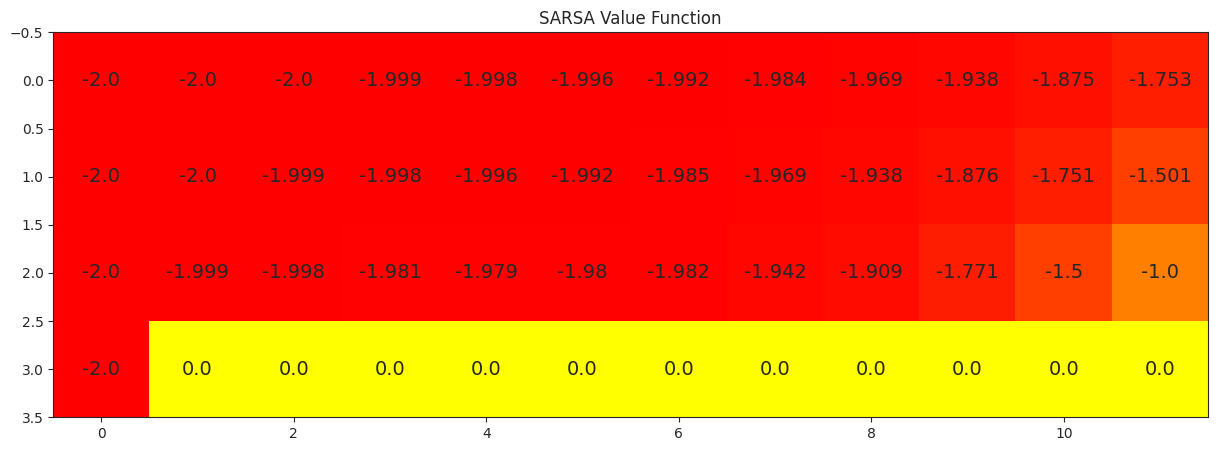

<Figure size 3840x2880 with 0 Axes>

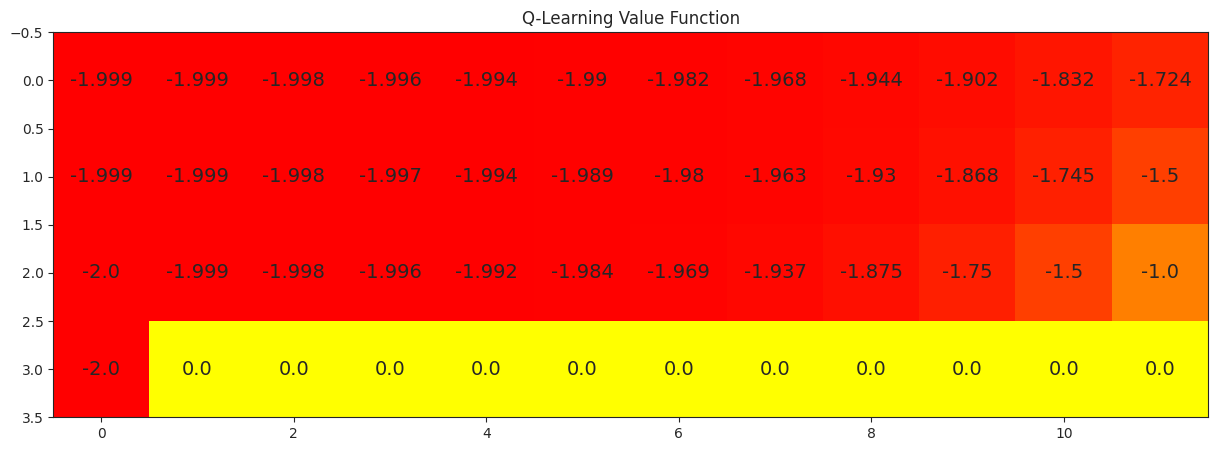

In [172]:
train()

# Experimenting with different values of EPSILON, ALPHA and GAMMA

100%|██████████| 50/50 [00:06<00:00,  7.97it/s]


SARSA Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| → | → | → | → | → | → | → | → | → | → | ↓ | ↓ |
| → | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| ↓ | ↑ | → | ↓ | → | ↓ | → | → | → | → | → | ↓ |
| ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ |
| → | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
SARSA Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |   |
| * | * | * | * | * | * | * | * | * | * | * | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Path
+---+---+-

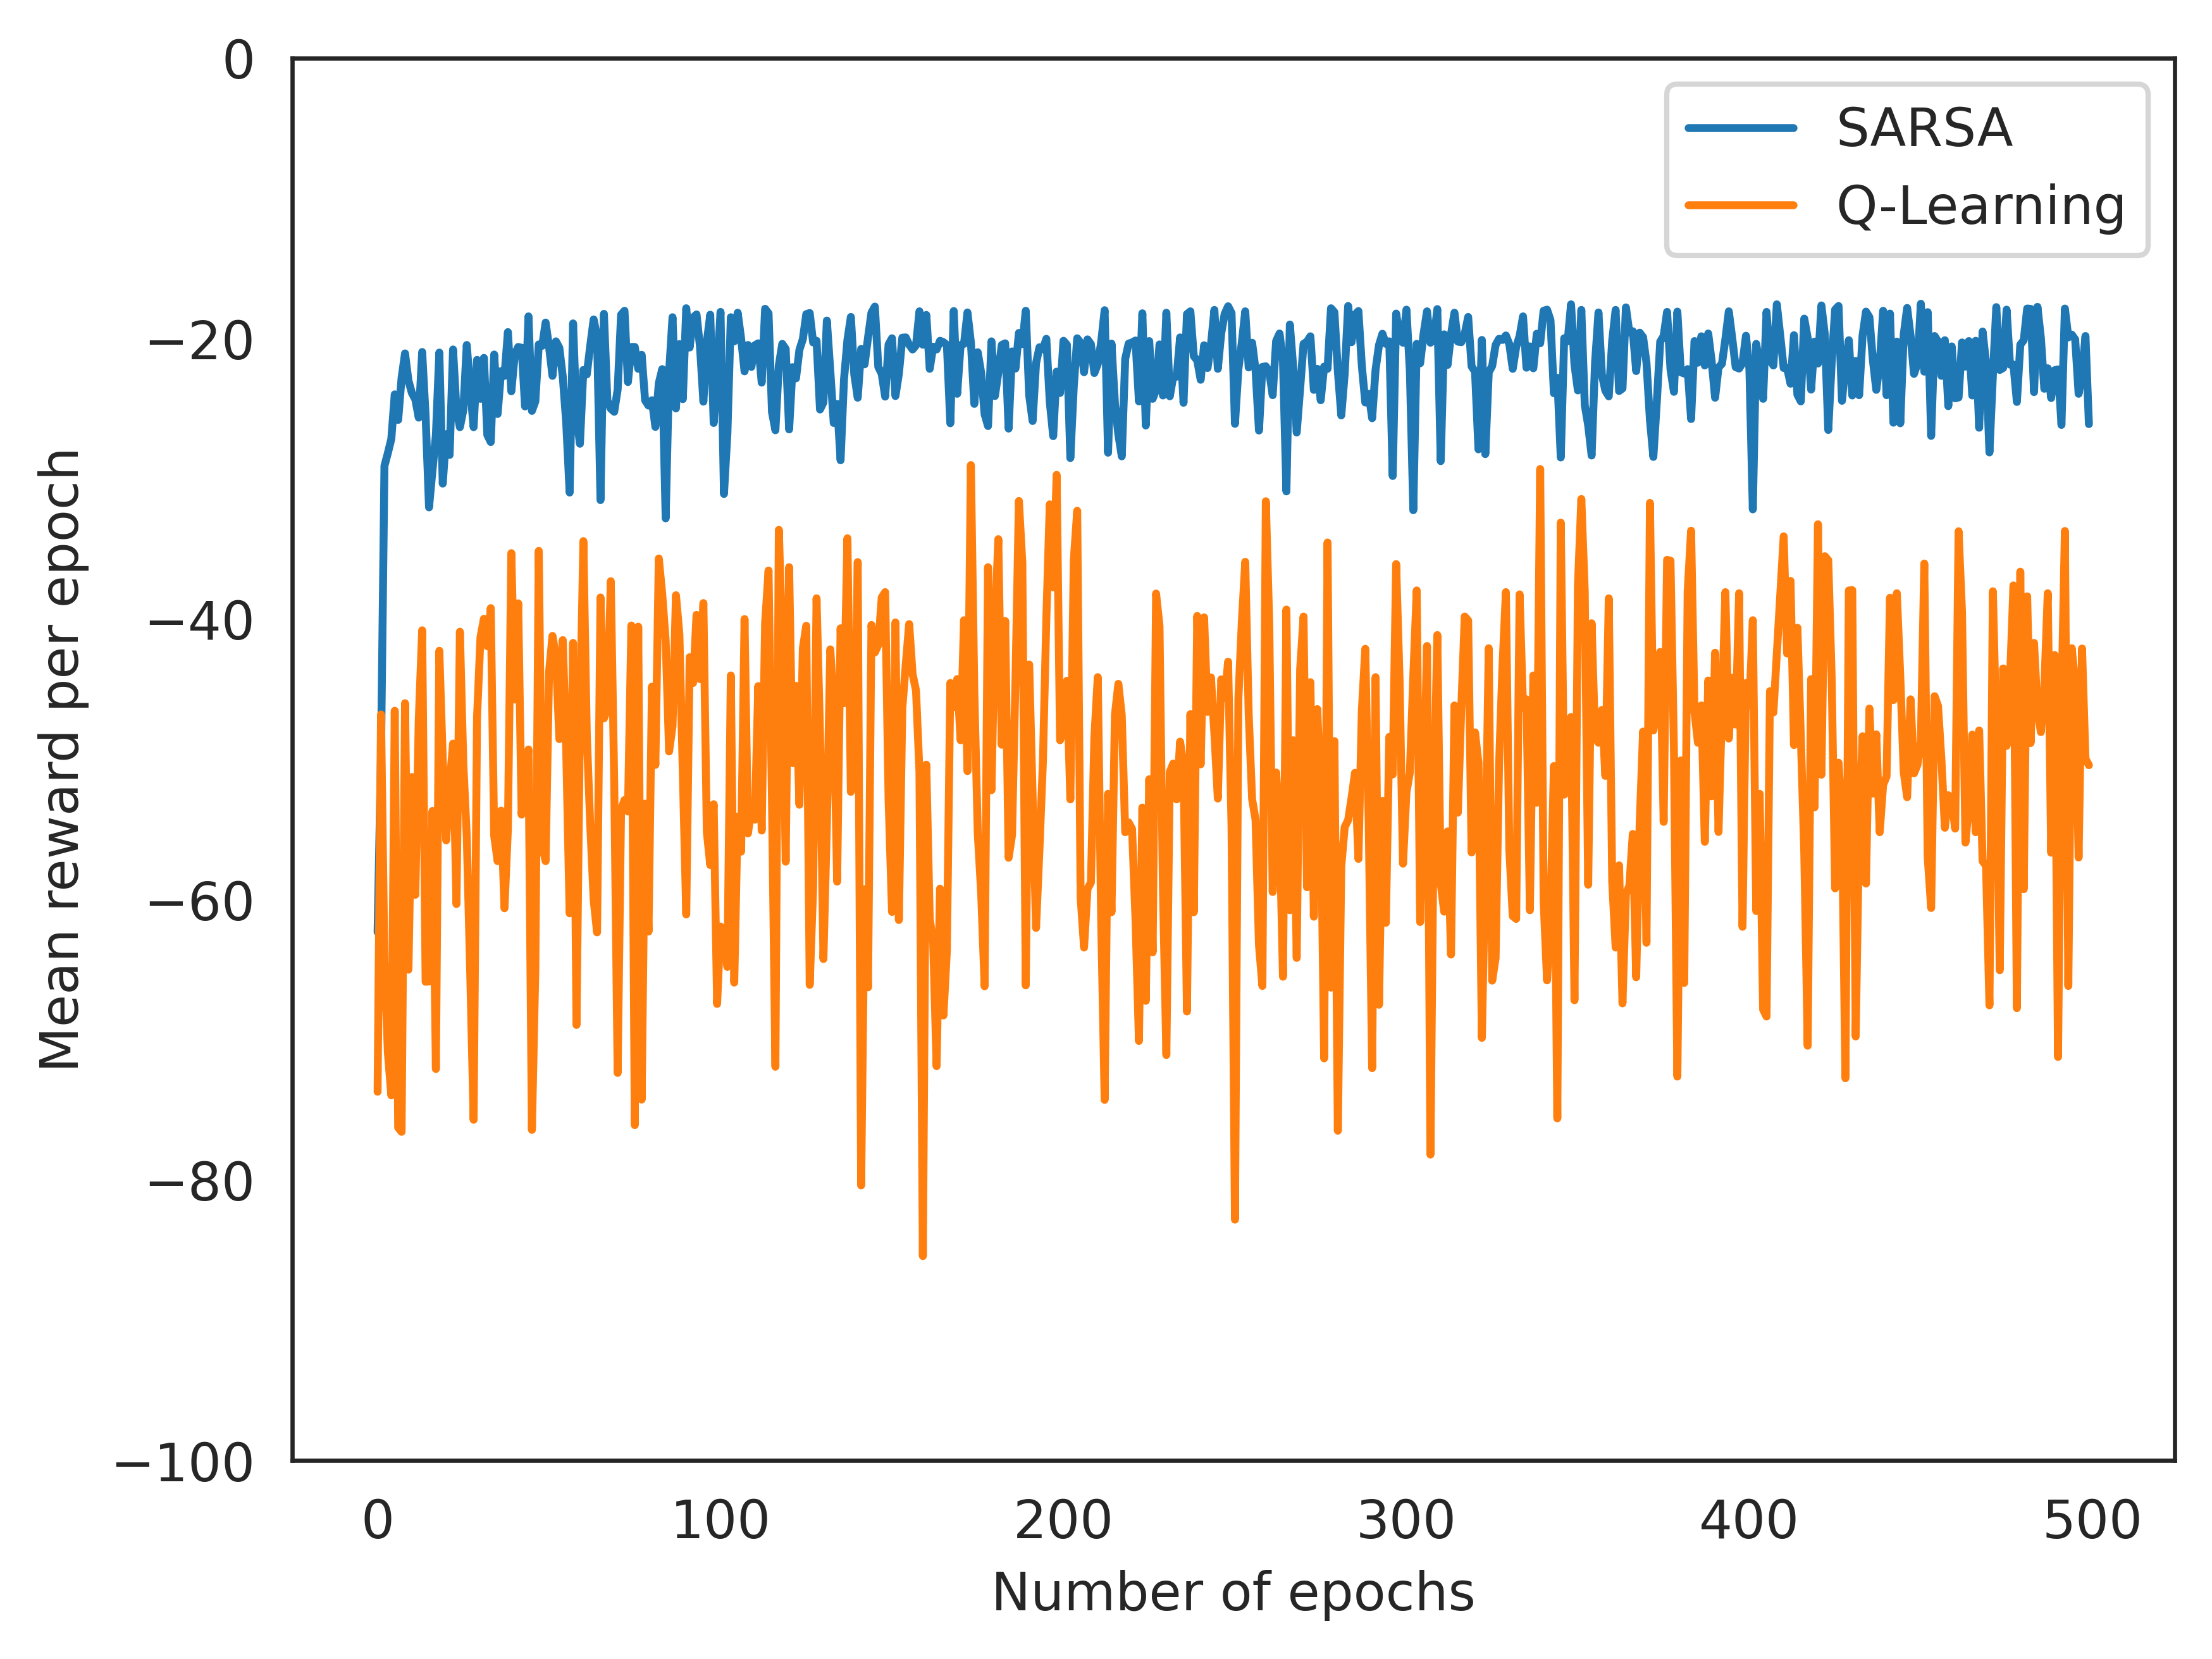

<Figure size 3840x2880 with 0 Axes>

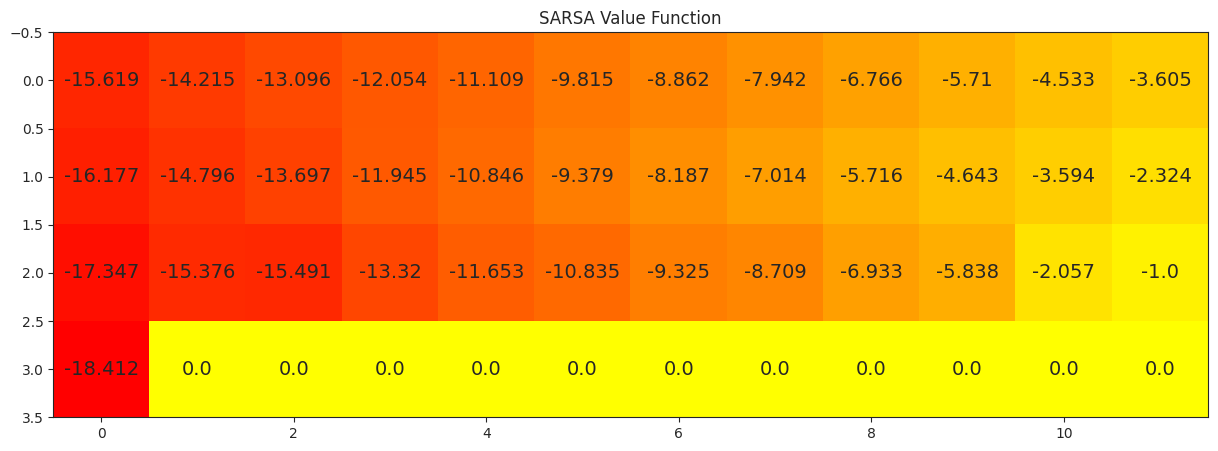

<Figure size 3840x2880 with 0 Axes>

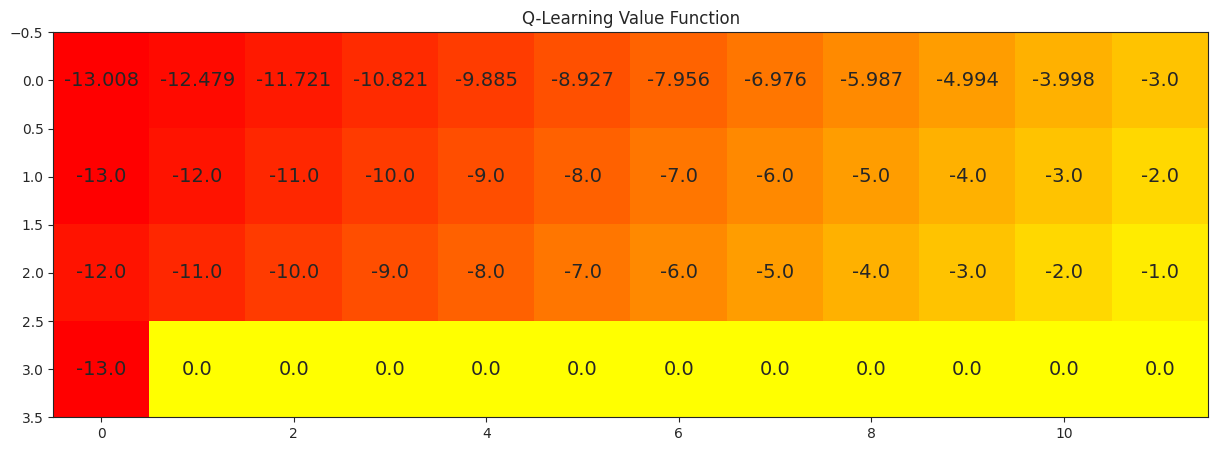

In [170]:
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 1
train()

100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


SARSA Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| → | → | → | → | → | → | ↓ | → | → | ↓ | → | ↓ |
| ↑ | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | → | ↑ | ← | ← | → | ← | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Policy
+---+---+---+---+---+---+---+---+---+---+---+---+
| ↑ | ↓ | → | → | ← | → | ↓ | → | ↓ | ← | → | ↓ |
| ↓ | ← | → | → | → | → | → | ↓ | ↑ | → | → | ↓ |
| → | → | → | → | → | → | → | → | → | → | → | ↓ |
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | G |
+---+---+---+---+---+---+---+---+---+---+---+---+
SARSA Optimal Path
+---+---+---+---+---+---+---+---+---+---+---+---+
| * | * | * | * | * | * | * |   |   |   |   |   |
| * |   |   |   |   |   | * | * | * | * | * | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
| * |   |   |   |   |   |   |   |   |   |   | * |
+---+---+---+---+---+---+---+---+---+---+---+---+
Q-Learning Optimal Path
+---+---+-

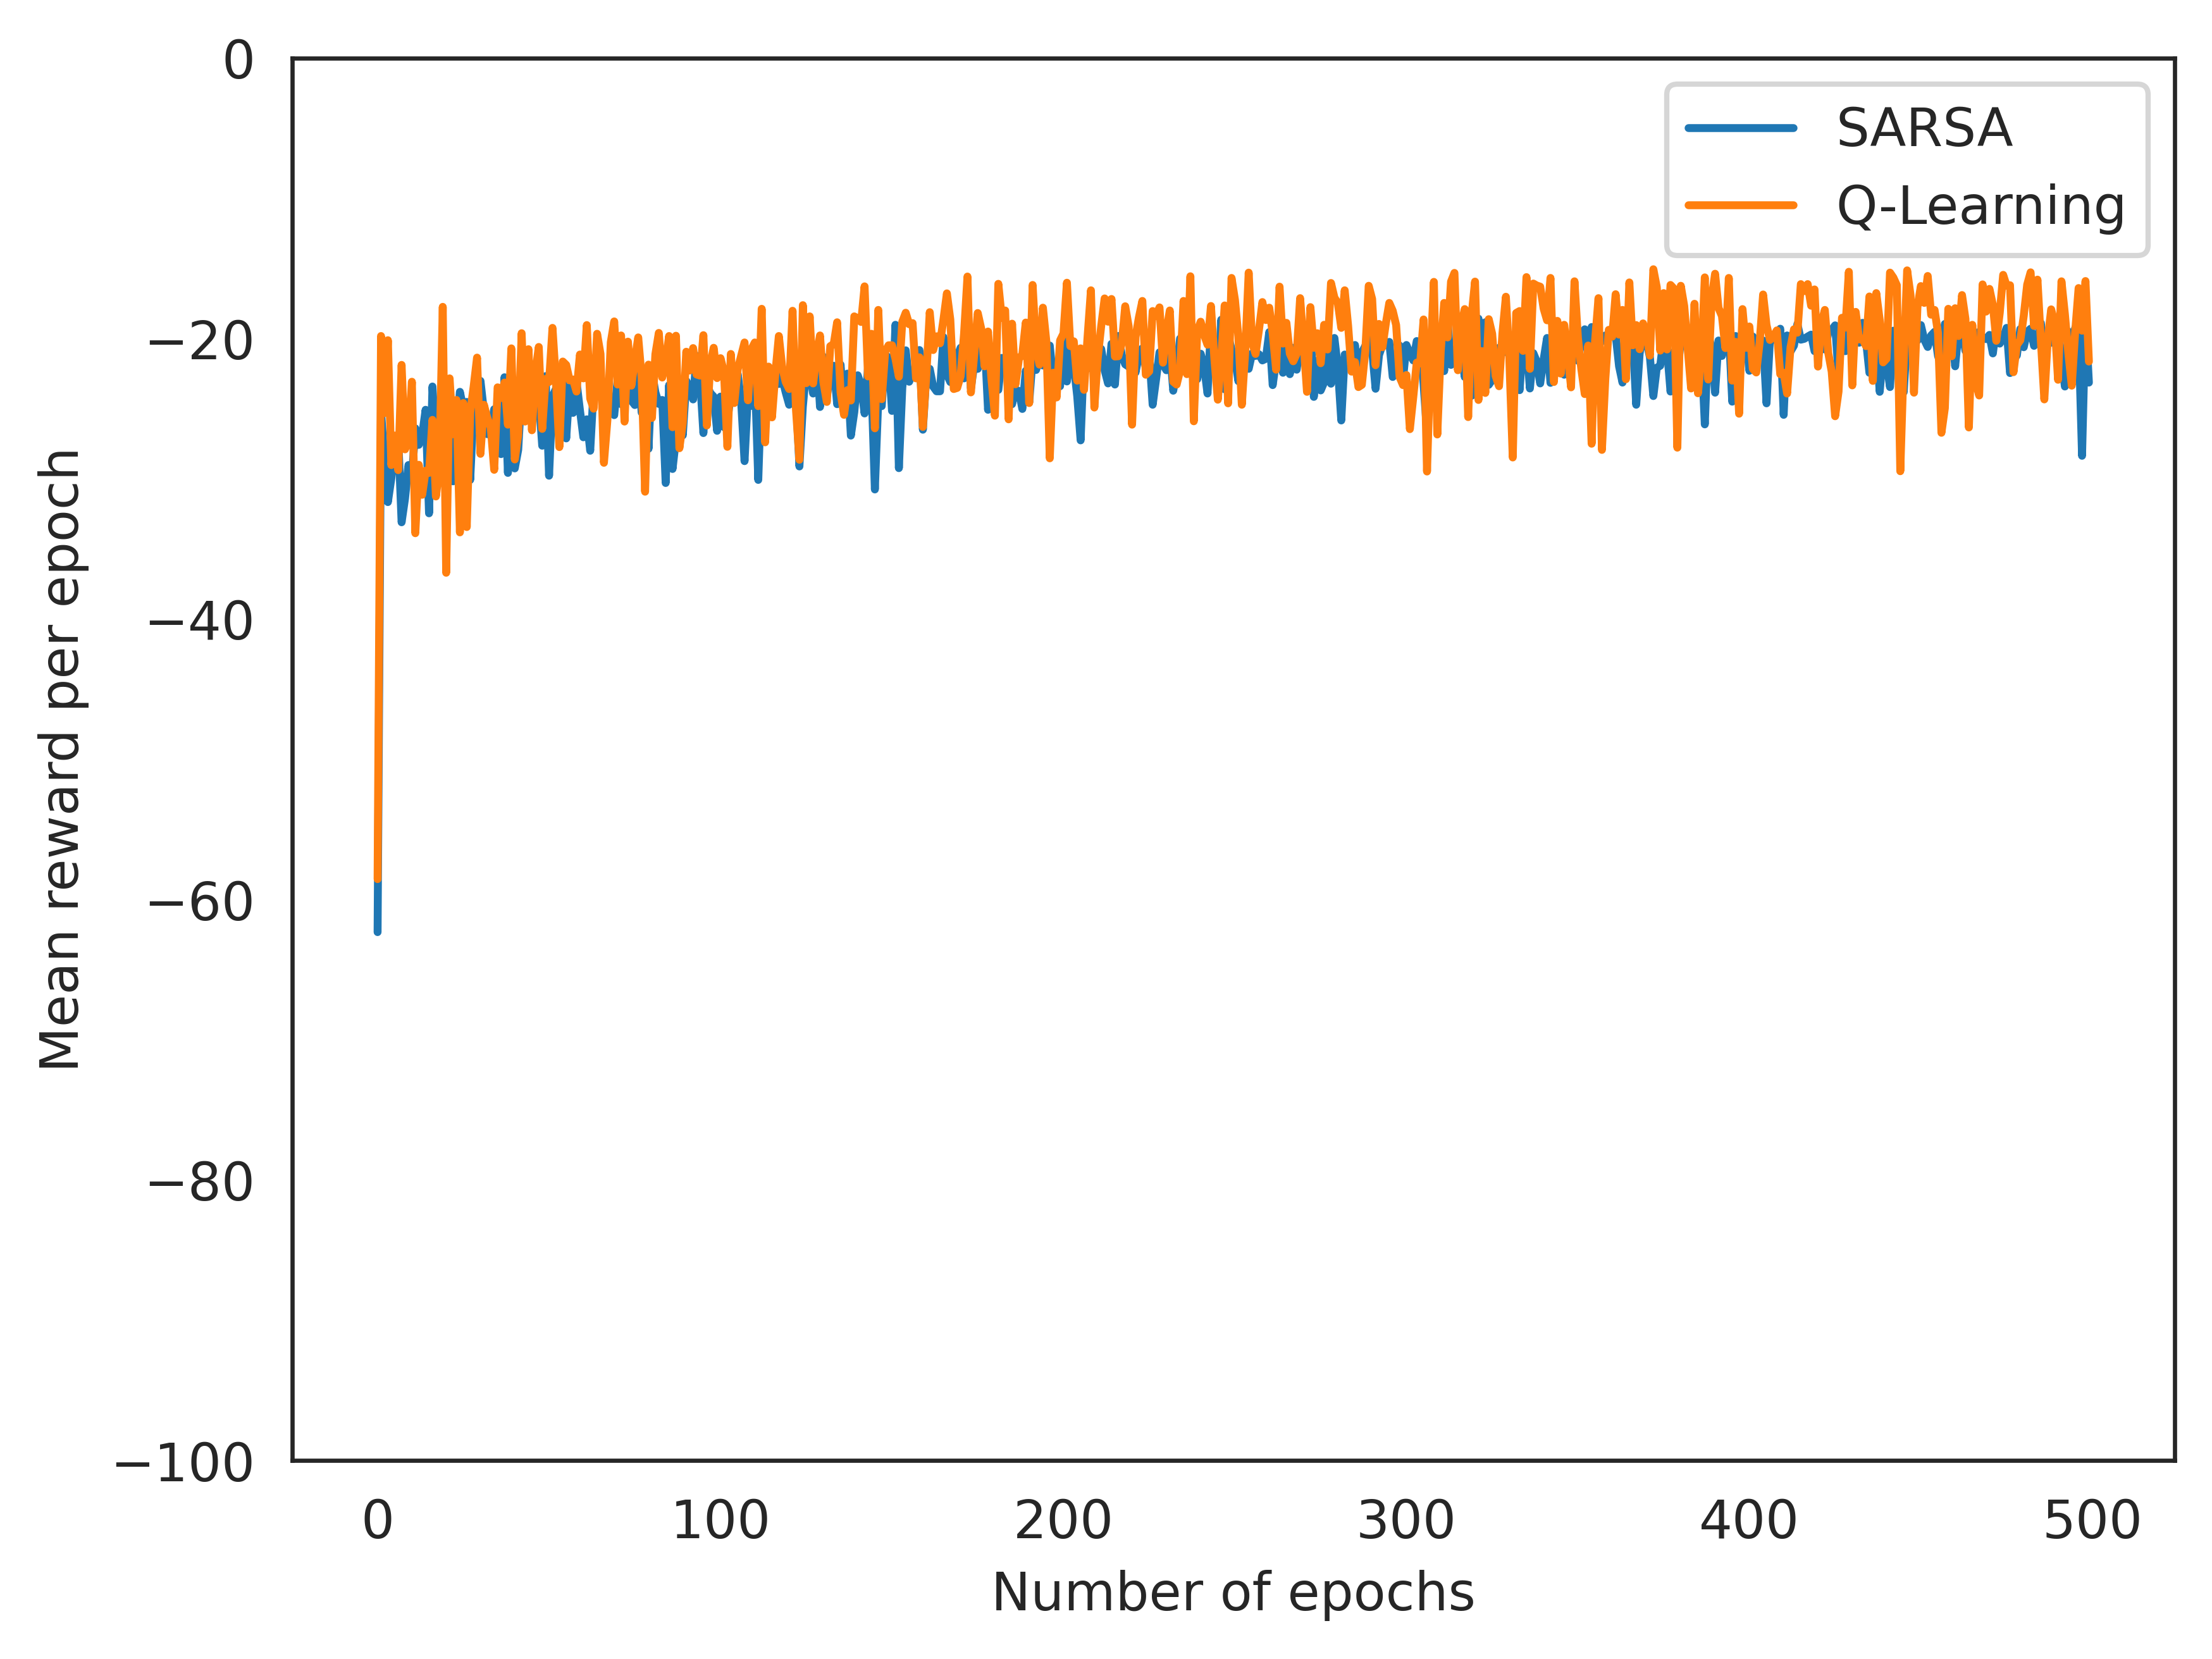

<Figure size 3840x2880 with 0 Axes>

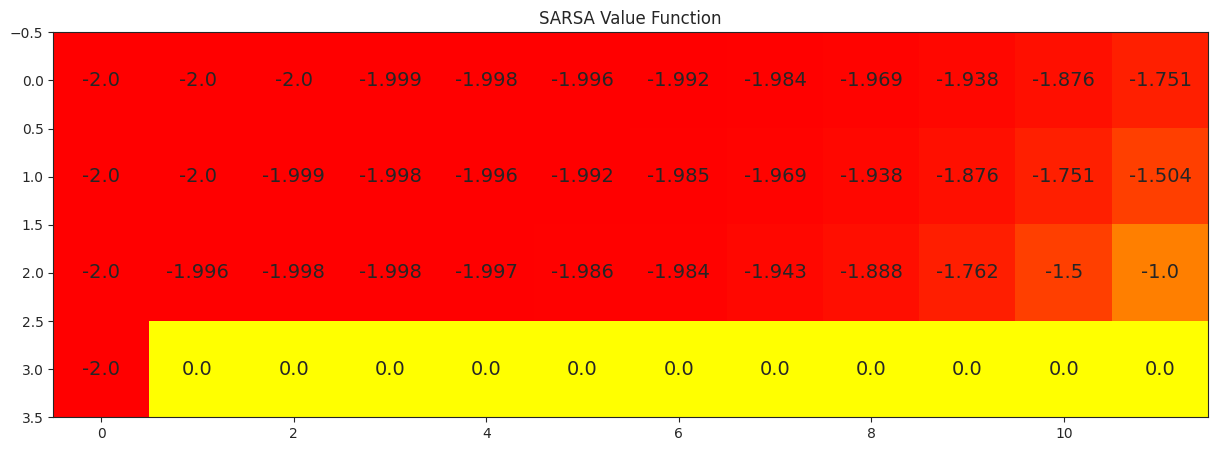

<Figure size 3840x2880 with 0 Axes>

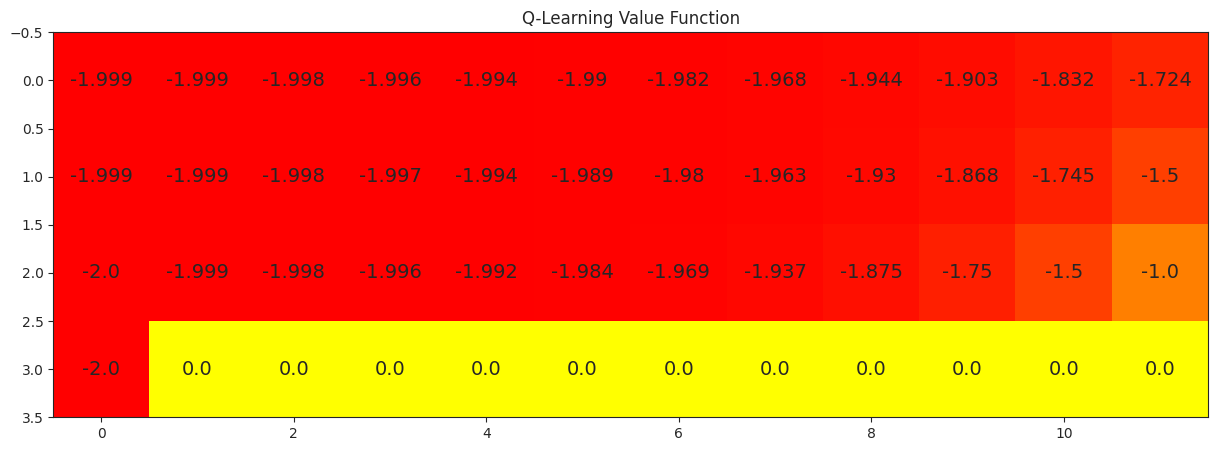

In [171]:
EPSILON = 0.01
ALPHA = 0.01
GAMMA = 0.5
train()

# Further experiments:




1. Try different values of EPSILON, ALPHA and GAMMA
2. Decay EPSILON and ALPHA
3. Try different reward formulations
4. More training to converge better: increase number of episodes
5. Expected SARSA
6. Tweak the environment